# 慢波扰动等离子体的状态方程

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
%config InlineBackend.figure_format = 'svg'

## 思路
- 当等离子体被一快波扰动，通常认为等离子体是绝热的；当被一慢波扰动，通常认为等离子体是等温的
- 我们将证明这只在Maxwellian等离子体下成立
- 对于kappa分布等离子体，慢波扰动等离子体状态方程是多方的，且多方指数和kappa相关

## 为验证想法，设计实验
- Valentini2012PoP 中构造了plateau分布函数
$$ f_p(v) = N \left\{ f(v) - \frac{f(v)-f(v_0)}{1+[(v-v_0)/\Delta v_p]^{n_p}} \right\} $$
其中$v_0$是平台处速率，$\Delta v_p$是平台宽度，$n_p$是光滑程度

- 该方法将分布函数在$v_0$处抹成平的

- 其图像为（$v_{th}=\sqrt{2}$, $v_0 = 1.5$, $\Delta v_p = 0.01$, $n_p=10$)

In [2]:
dv_p = 0.3
n_p = 10
v_0 = 0.5
v_th = np.sqrt(2)
kappa = 1
n = 1

def f_eq(v):
    #Maxwellian PDF
    r = np.exp(-v**2/v_th**2) / np.sqrt(np.pi) / v_th
    #kappa PDF
    rv = ( 1 + (v/v_th)**2/kappa )**(-kappa)
    A = n/np.sqrt(np.pi*kappa)/v_th * sp.gamma(kappa)/sp.gamma(kappa-1/2)
#     r = A*rv
    return r

def f_p_unnorm(v):
    N = f_eq(v) - f_eq(v_0)
    if v>0:
        D = 1 + ((v-v_0)/dv_p)**n_p
    else:
        D = 1 + ((v+v_0)/dv_p)**n_p
    r = f_eq(v) - N/D
    return r

norm = integrate.quad(f_p_unnorm,-np.inf,np.inf)[0]

def f_p_nonvec(v):
    return f_p_unnorm(v)/norm

f_p = np.vectorize(f_p_nonvec)

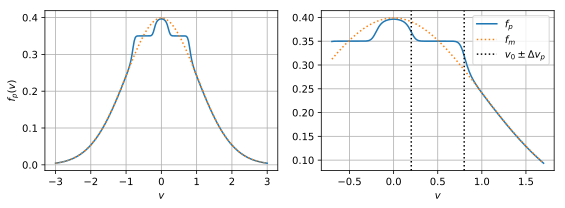

In [3]:
v_global = np.linspace(-3,3,num=200)
v_local_1 = np.linspace(v_0-0.2,v_0+0.2,num=200)
v_local_2 = np.linspace(v_0-dv_p*4,v_0+dv_p*4,num=200)

fig = plt.figure(figsize=(8,3))
ax1 = plt.subplot(121)
ax1.plot(v_global,f_p(v_global))
ax1.plot(v_global,f_eq(v_global),':',label=r'$f_m$')
# ax1.set_yscale('log')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_p(v)$')
ax1.grid()

ax3 = plt.subplot(122)
ax3.plot(v_local_2,f_p(v_local_2),label=r'$f_p$')
ax3.plot(v_local_2,f_eq(v_local_2),':',label=r'$f_m$')
ax3.axvline(x=v_0-dv_p,linestyle=':',color='black')
ax3.axvline(x=v_0+dv_p,linestyle=':',color='black',label=r'$v_0 \pm \Delta v_p$')
ax3.set_xlabel(r'$v$')
ax3.legend()
ax3.grid()
plt.tight_layout()
plt.show()

## 模拟验证

### 模拟参数设定

In [15]:
T = 1
k = 1
L = 2*np.pi/k

vmax = 5 # 速度最大值
nx = 200
nv = 2000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.02
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 1e-3
linear_time = 2*np.pi/np.sqrt(d)

path = '../data/'
print(data_num)
print('k=',k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('linear time=',linear_time)

2
k= 1
limited time= 1256.0087429051994
real time =  200.0
linear time= 198.69176531592203


### 模拟结果

In [16]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

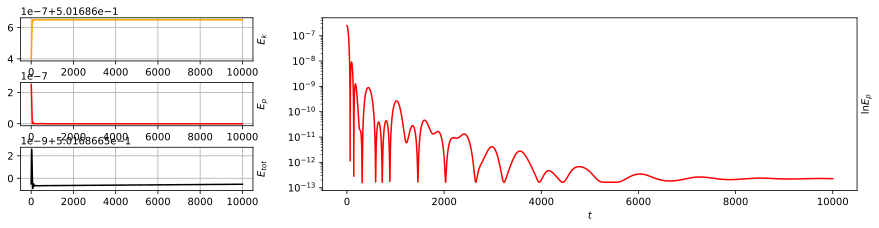

In [17]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [18]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [19]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

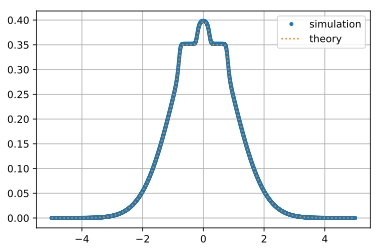

In [20]:
plt.plot(v,fv0,'.',label='simulation')
plt.plot(v,f_p(v),':',label='theory')
plt.grid()
# plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [21]:
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

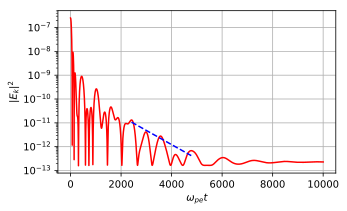

In [24]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[10:15:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

fig = plt.figure(figsize=(5,3))
plt.plot(t,dataep,color='red')
plt.plot(xep,np.exp(line(para,xep)), '--',color='b')
plt.xlabel(r'$\omega_{pe}t$')
plt.ylabel(r'$|E_k|^2$')
plt.yscale('log')
plt.grid()
plt.show()

In [25]:
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory',round(v_0*k,6),0])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
# com_table.add_row(['Error(%)',round(wr0_err,6),round(abs(wi0_err),6)])
print(com_table)

+------------+----------+----------+
|  EAW: k=1  |    wr    |    wi    |
+------------+----------+----------+
|   Theory   |   0.5    |    0     |
| Simulation | 0.275578 | 0.034238 |
+------------+----------+----------+
